## Reproducing Simulation result
### Null simulation
We share the pre-computed null simulation results for GWAS/FINDOR/GWAS in the data folder. We first load it via:

In [ ]:
import pandas as pd
import multiprocessing
from tqdm import tqdm
import numpy as np
import sys
sys.path.append('../')
from kgwas.eval_utils import get_clumps_gold_label, get_meta_clumps, get_mega_clump_query, get_curve

data_path = '/dfs/project/datasets/20220524-ukbiobank/data/kgwas_data/'
snp_info = pd.read_csv(data_path + 'misc_data/snp_qc_info.csv')

df_gwas = pd.read_csv(data_path + 'model_pred/simulation/null_simulation_gwas.csv')
df_kgwas = pd.read_csv(data_path + 'model_pred/simulation/null_simulation_kgwas.csv')
df_findor = pd.read_csv(data_path + 'model_pred/simulation/null_simulation_findor.csv')

df_gwas = snp_info.merge(df_gwas, left_on = 'SNP', right_on = 'ID')
df_kgwas = snp_info.merge(df_kgwas, left_on = 'SNP', right_on = 'ID')
df_findor = snp_info.merge(df_findor)

This dataframe saves p-values for all the 500 seeds:

In [11]:
df_findor

,CHR,SNP,POS,A1,A2,N,AF1,P_seed1,P_seed2,P_seed3,...,P_seed491,P_seed492,P_seed493,P_seed494,P_seed495,P_seed496,P_seed497,P_seed498,P_seed499,P_seed500
0,1,rs3131962,756604,A,G,155603,0.129731,1.039910,0.966660,1.015493,...,1.039910,0.110102,0.370526,0.991077,1.064326,0.202375,1.015493,0.435631,1.039910,0.673215
1,1,rs12562034,768448,A,G,155612,0.105188,0.478095,0.069428,1.015493,...,0.232310,0.008637,1.039910,0.735306,0.432725,1.039910,1.015493,0.769550,1.039910,0.076054
2,1,rs4040617,779322,G,A,155423,0.127632,1.039910,0.966660,1.015493,...,1.039910,0.385465,0.051355,0.991077,1.064326,1.039910,1.015493,0.991077,0.094461,1.015493
3,1,rs79373928,801536,G,T,155775,0.014890,1.039910,0.966660,1.015493,...,1.039910,1.015493,1.039910,0.991077,1.064326,0.102502,1.015493,0.230932,1.039910,0.128050
4,1,rs11240779,808631,G,A,154651,0.225226,0.649663,0.966660,0.323705,...,1.039910,1.015493,0.025025,0.991077,1.064326,0.782647,0.794389,0.991077,0.154599,0.256710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524827,22,rs73174435,51174939,T,C,155675,0.053374,0.007886,0.037670,1.015493,...,0.178205,0.854147,0.203594,0.991077,1.064326,0.573911,1.015493,0.146576,0.722465,1.015493
524828,22,rs3810648,51175626,G,A,154836,0.060984,1.039910,0.966660,1.015493,...,1.039910,0.224030,1.039910,0.991077,0.002261,1.039910,0.056953,0.389743,1.039910,0.930820
524829,22,rs5771002,51183255,A,G,153451,0.334621,1.039910,0.966660,1.015493,...,1.039910,1.015493,0.043223,0.991077,1.064326,1.039910,1.015493,0.991077,1.039910,0.395818
524830,22,rs3865764,51185848,G,A,155442,0.050797,0.299359,0.966660,1.015493,...,1.039910,1.015493,1.039910,0.991077,1.064326,0.280792,0.584575,0.844995,1.039910,0.281122


Now, let's count the number of discoveries on the even chromosomes, which are used as a proxy for the number of false discoveries. The goal is to compare against GWAS, and if it has the same number of false discoveries, we are confident that KGWAS is calibrated.

In [ ]:
t_p = 5e-8
def get_stats(seed):
    stats = {}
    df_gwas_temp = df_gwas[['SNP', 'CHR', 'P_seed'+str(seed)]]
    df_kgwas_temp = df_kgwas[['SNP', 'CHR', 'P_seed'+str(seed)]]
    df_findor_temp = df_findor[['SNP', 'CHR', 'P_seed'+str(seed)]]

    ## Get number of discoveries on the even chromsomes => they are false discoveries
    df_gwas_temp = df_gwas_temp[df_gwas_temp['CHR'].apply(lambda x: x%2==0)]
    clumps = get_clumps_gold_label(data_path, df_gwas_temp, t_p = t_p, no_hla = True, column = 'P_seed'+str(seed)) ## merge LD blocks
    idx2mega_clump, idx2mega_clump_rsid, idx2mega_clump_chrom = get_meta_clumps(clumps, data_path) ## merging LD blocks within 0.1 cM
    stats['gwas_num_false_pos'] = len([j for i,j in idx2mega_clump_rsid.items()])

    df_kgwas_temp = df_kgwas_temp[df_kgwas_temp['CHR'].apply(lambda x: x%2==0)]
    clumps_kgwas = get_clumps_gold_label(data_path,df_kgwas_temp, t_p = t_p, no_hla = True, column = 'P_seed'+str(seed))
    idx2mega_clump, idx2mega_clump_rsid, idx2mega_clump_chrom = get_meta_clumps(clumps_kgwas, data_path) 
    stats['kgwas_num_false_pos'] = len([j for i,j in idx2mega_clump_rsid.items()])

    df_findor_temp = df_findor_temp[df_findor_temp['CHR'].apply(lambda x: x%2==0)]
    clumps_findor = get_clumps_gold_label(data_path, df_findor_temp, t_p = t_p, no_hla = True, column = 'P_seed'+str(seed))
    idx2mega_clump, idx2mega_clump_rsid, idx2mega_clump_chrom = get_meta_clumps(clumps_findor, data_path) 
    stats['findor_num_false_pos'] = len([j for i,j in idx2mega_clump_rsid.items()])

    return stats

In [21]:
seed_list = list(range(1, 501))
import multiprocessing
from tqdm import tqdm
with multiprocessing.Pool(10) as p:
    res = list(tqdm(p.imap(get_stats, seed_list), total=len(seed_list)))

100%|██████████| 500/500 [15:28<00:00,  1.86s/it]


In [ ]:
res_all = []
for x in tqdm(res):
    res_all += [[x['gwas_num_false_pos'], 'GWAS']]
    res_all += [[x['kgwas_num_false_pos'], 'KGWAS']]
    res_all += [[x['findor_num_false_pos'], 'FINDOR']]
df_size2res_sig = pd.DataFrame(res_all).rename(columns = {0: '# False Pos.', 1: 'Method'})

100%|██████████| 500/500 [00:00<00:00, 424610.65it/s]


Let's plot the same figure as in the paper!

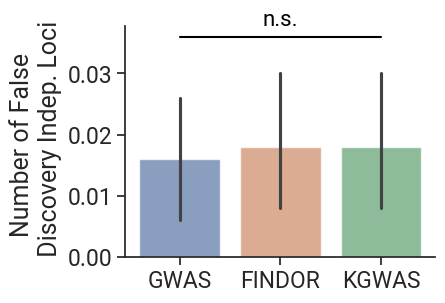

In [43]:
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt
from tqdm import tqdm

font_dirs = ["/dfs/project/datasets/20220524-ukbiobank/data/kgwas_data/misc_data/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
sns.set(rc={'figure.figsize':(4,3)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font="Roboto", font_scale=1.5)
plt.rc('axes', unicode_minus=False)

data_gwas = df_size2res_sig[(df_size2res_sig['Method'] == 'GWAS') ]['# False Pos.']
data_kgwas = df_size2res_sig[(df_size2res_sig['Method'] == 'KGWAS')]['# False Pos.']
# T-test
t_stat, p_val = ttest_ind(data_gwas, data_kgwas, equal_var=False)  # Assuming unequal variances

# Create the barplot
g = sns.barplot(data=df_size2res_sig, x='Method', y='# False Pos.', order = ['GWAS', 'FINDOR', 'KGWAS'], hue = 'Method', hue_order = ['GWAS', 'FINDOR', 'KGWAS'], alpha=0.7)
g.set(ylabel='Number of False \n Discovery Indep. Loci', xlabel = '')


gwas_bar = plt.gca().patches[0]
kgwas_bar = plt.gca().patches[2]

max_height = max(gwas_bar.get_height(), kgwas_bar.get_height())

# Define where to place the bracket
bracket_height = max_height * 2

# Draw the bracket and label based on p-value
plt.plot([gwas_bar.get_x() + gwas_bar.get_width() / 2, kgwas_bar.get_x() + kgwas_bar.get_width() / 2],
            [bracket_height, bracket_height], color='black', lw=1.5)

label = f'p = {p_val:.3f}' if p_val < 0.05 else f'n.s.'
plt.text((gwas_bar.get_x() + kgwas_bar.get_x()) / 2 + kgwas_bar.get_width() / 2, bracket_height + 0.001, label,
            ha='center', va='bottom', color='black', fontsize=16)

sns.despine()
plt.show()


We can see that majority of the 500 runs have 0 false discoveries. A few of them have at most 1 false discovery.

[Text(0, 0.5, 'Number of False \n Discovery Indep. Loci'), Text(0.5, 0, '')]

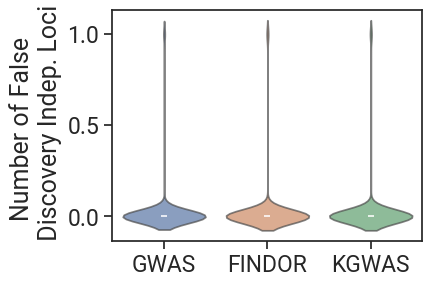

In [ ]:
g = sns.violinplot(data=df_size2res_sig, x='Method', y='# False Pos.', order = ['GWAS', 'FINDOR', 'KGWAS'], hue = 'Method', hue_order = ['GWAS', 'FINDOR', 'KGWAS'], alpha=0.7)
g.set(ylabel='Number of False \n Discovery Indep. Loci', xlabel = '')

In [44]:
df_size2res_sig.groupby('Method')['# False Pos.'].mean()

Method
FINDOR    0.018
GWAS      0.016
KGWAS     0.018
Name: # False Pos., dtype: float64

Awesome - now, let's look at the causal simulation. Similarly, we first need to load the data.

In [1]:
df_gwas = pd.read_csv(data_path + 'model_pred/simulation/causal_simulation_gwas.csv')
df_kgwas = pd.read_csv(data_path + 'model_pred/simulation/causal_simulation_kgwas.csv')
df_findor = pd.read_csv(data_path + 'model_pred/simulation/causal_simulation_findor.csv')

df_gwas = snp_info.merge(df_gwas, left_on = 'SNP', right_on = 'ID')
df_kgwas = snp_info.merge(df_kgwas, left_on = 'SNP', right_on = 'ID')
df_findor = snp_info.merge(df_findor)

For causal simulation, we need to know the ground truth causal variants. We can load it via:

In [2]:
import pickle
causal_variants = pickle.load(open(data_path + 'model_pred/simulation/causal_variants.pkl', 'rb'))
causal_variants[1]

array(['rs77902650', 'rs34970007', 'rs2260000', ..., 'rs61746937',
       'rs35667233', 'rs4277734'], dtype=object)

In [5]:
import copy
t_p = 5e-8

def get_stats(seed):
    stats = {}
    base_gwas = df_gwas[['SNP', 'CHR', 'P_seed'+str(seed)]].rename(columns = {'P_seed'+str(seed): 'P'})
    kgwas = df_kgwas[['SNP', 'CHR', 'P_seed'+str(seed)]].rename(columns = {'P_seed'+str(seed): 'P'})
    findor = df_findor[['SNP', 'CHR', 'P_seed'+str(seed)]].rename(columns = {'P_seed'+str(seed): 'P'})

    # create a fake ground truth sum stats with causal variants have extremely low p-values
    causal_snps = causal_variants[seed]
    gold_label_gwas = copy.deepcopy(snp_info)
    gold_label_gwas['P'] = 1
    gold_label_gwas.loc[gold_label_gwas['SNP'].isin(causal_snps), 'P'] = 0

    gold_snps = gold_label_gwas[gold_label_gwas.P < t_p].SNP.values
    clumps = get_clumps_gold_label(data_path, gold_label_gwas, t_p = t_p, no_hla = True) 
    idx2mega_clump, idx2mega_clump_rsid, idx2mega_clump_chrom = get_meta_clumps(clumps, data_path) ## filtering cM
    mega_clump_gold = [j for i,j in idx2mega_clump_rsid.items()]
    
    def get_scores(base_gwas, name):
        frac2res = {}
        base_gwas['logp'] = -np.log10(base_gwas['P'])
        snp2rank = dict(base_gwas[['SNP', 'logp']].values)
        snp_hits = base_gwas.sort_values('P').SNP.values

        idx2mega_clump_pred, idx2mega_clump_rsid_pred, idx2mega_clump_chrom_pred = get_mega_clump_query(data_path, clumps, snp_hits, no_hla = True) 
        idx2mega_clump_rank_pred = {i: max([snp2rank[x] for x in j  if x in snp2rank]) for i,j in idx2mega_clump_rsid_pred.items()}
        idx2mega_clump_rank_pred = dict(sorted(idx2mega_clump_rank_pred.items(), key=lambda item: item[1])[::-1]) ## rank based on logp
        mega_clump_pred = [idx2mega_clump_rsid_pred[i] for i in list(idx2mega_clump_rank_pred.keys())][:1000] ## top 1000 predicted clumps
        frac2res['recall_k_base_gwas'], frac2res['precision_k_base_gwas'], frac2res['k_to_clump_idx_base_gwas'] = get_curve(mega_clump_pred, mega_clump_gold)
        frac2res['mega_clump_pred_base_gwas'] = mega_clump_pred
        frac2res['mega_clump_gold'] = mega_clump_gold

        rs_to_p = dict(base_gwas[['SNP', 'P']].values)
        mega_clump_sign = []
        for idx, mega_clump in enumerate(mega_clump_pred):
            if min([rs_to_p[rs] for rs in mega_clump if rs in rs_to_p]) <= 5e-8:
                ## is significant givent this threshold
                mega_clump_sign.append(idx)

        mega_clump_sign_rep = []
        for idx in mega_clump_sign:
            if len(np.intersect1d(mega_clump_pred[idx], gold_snps)) > 0:
                mega_clump_sign_rep.append(idx)
        frac2res['num_significant_' + str(5e-8) +'_' + name] = len(mega_clump_sign)
        frac2res['num_significant_replicated_' + str(5e-8) + '_' + name] = len(mega_clump_sign_rep)
        return frac2res

    stats['gwas'] = get_scores(base_gwas, 'gwas')
    stats['kgwas'] = get_scores(kgwas, 'kgwas')
    stats['findor'] = get_scores(findor, 'findor')
    return stats

In [6]:
seed_list = list(range(1, 101))
with multiprocessing.Pool(10) as p:
    res = list(tqdm(p.imap(get_stats, seed_list), total=len(seed_list)))

100%|██████████| 100/100 [1:21:07<00:00, 48.67s/it]


In [ ]:
result = ([['GWAS', i['gwas']['num_significant_replicated_5e-08_gwas']] for i in res] + [['KGWAS', i['kgwas']['num_significant_replicated_5e-08_kgwas']] for i in res] + [['FINDOR', i['findor']['num_significant_replicated_5e-08_findor']] for i in res])
df_size2res_sig = pd.DataFrame(result).rename(columns = {1: '# of hits', 0: 'Method'})

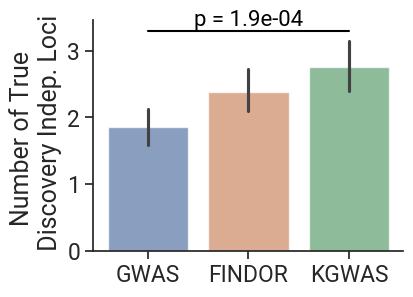

In [ ]:
data_gwas = df_size2res_sig[(df_size2res_sig['Method'] == 'GWAS') ]['# of hits']
data_kgwas = df_size2res_sig[(df_size2res_sig['Method'] == 'KGWAS')]['# of hits']
# T-test
t_stat, p_val = ttest_ind(data_gwas, data_kgwas, equal_var=False)  # Assuming unequal variances

# Create the barplot
g = sns.barplot(data=df_size2res_sig, x='Method', y='# of hits', order = ['GWAS', 'FINDOR', 'KGWAS'], hue = 'Method', hue_order = ['GWAS', 'FINDOR', 'KGWAS'], alpha=0.7)
g.set(ylabel='Number of True \n Discovery Indep. Loci', xlabel = '')

gwas_bar = plt.gca().patches[0]
kgwas_bar = plt.gca().patches[2]

max_height = max(gwas_bar.get_height(), kgwas_bar.get_height())

# Define where to place the bracket
bracket_height = max_height * 1.2

# Draw the bracket and label based on p-value
plt.plot([gwas_bar.get_x() + gwas_bar.get_width() / 2, kgwas_bar.get_x() + kgwas_bar.get_width() / 2],
            [bracket_height, bracket_height], color='black', lw=1.5)

label = f'p = {p_val:.1e}' if p_val < 0.05 else f'n.s.'
plt.text((gwas_bar.get_x() + kgwas_bar.get_x()) / 2 + kgwas_bar.get_width() / 2, bracket_height + 0.001, label,
            ha='center', va='bottom', color='black', fontsize=16)

sns.despine()
plt.show()

[Text(0, 0.5, 'Number of True \n Discovery Indep. Loci'), Text(0.5, 0, '')]

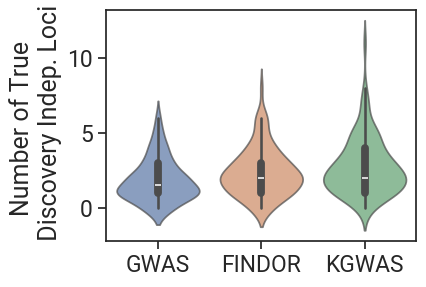

In [26]:
g = sns.violinplot(data=df_size2res_sig, x='Method', y='# of hits', order = ['GWAS', 'FINDOR', 'KGWAS'], hue = 'Method', hue_order = ['GWAS', 'FINDOR', 'KGWAS'], alpha=0.7)
g.set(ylabel='Number of True \n Discovery Indep. Loci', xlabel = '')